In [1]:
#!/usr/bin/env python3
# Importing required packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] : 20
import nlopt
import scipy.stats as stats
from scipy.interpolate import UnivariateSpline

In [2]:
# Create a vector of unknown parameter values
a = np.zeros(2)  # Vector of unknown parameter values
Tend = 100          # Maximum time horizon
T0 = 180.0          # Initial temperature - fixed constant
σ = 8.0             # Standard deviation for additive Gaussian Noise model - fixed constant
t = np.linspace(0, Tend, 11)   # Discretised time variable, coarse discretisation
tt = np.linspace(0, Tend, 101) # Discretised time variable, fine discretisation

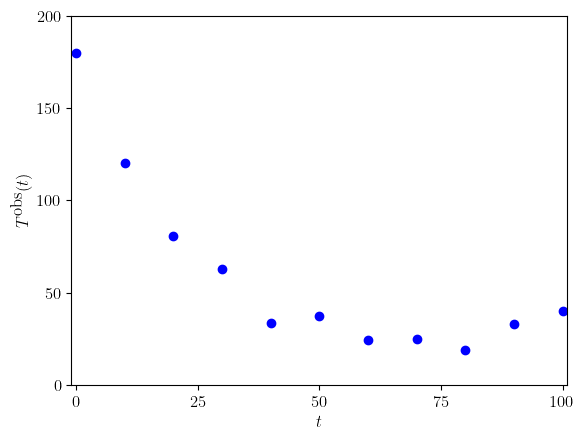

In [3]:
data = np.array([180,120.23289494816545,80.80223383339003,63.043377610898446,33.82110519931399,37.58253928898577,
    24.466743123119954,25.20867035519172,18.974232471938194,33.03717277223526,40.23754940875503]) # Observed data
# p1 is the plot of the observed data
fig1, ax1 = plt.subplots()
ax1.scatter(t, data, color='blue')  
ax1.set_xlabel(r"$t$",fontsize=12)
ax1.set_ylabel(r"$T^{\textrm{obs}}(t)$",fontsize=12)
ax1.set_xlim(t[0]-1, t[-1]+1)
ax1.set_ylim(0, 200)
ax1.set_xticks([0,25,50,75,100])
ax1.set_xticklabels([r"$0$", r"$25$", r"$50$", r"$75$", r"$100$"],fontsize=12)
ax1.set_yticks([0,50,100,150,200])
ax1.set_yticklabels([r"$0$", r"$50$", r"$100$", r"$150$", r"$200$"],fontsize=12);

Process model

\begin{align}
\large{\dfrac{\textrm{d}T(t)}{\textrm{d}t}}&=\large{- k \left(T(t) - T_a\right),} \notag \\  
\large{T(t)} &\large{= \left(T(0) - T_{\textrm{a}} \right)\textrm{e}^{-kt} + T_{\textrm{a}}.}
\end{align}

For simplicity, let's assume that $T(0)$ is known (e.g. measurable)

\begin{equation}
\large{\theta = (T_{\textrm{a}},k)^\mathsf{T}}
\end{equation}

In [4]:
def model(t, T0, a):
    # function to evaluate the mathematical model, input the time vector t,
    # the initial temperature T0 and the vector of parameters a = (T_a,k)
    y = np.zeros(len(t))
    def T(t_val):
        return a[0] + (T0 - a[0]) * np.exp(-a[1] * t_val)
    for i in range(len(t)):
        y[i] = T(t[i])
    return y

Noise (measurement) model: Additive Gaussian

\begin{equation}
\large{T^{\textrm{obs}}(t) \mid \theta = \mathcal{N}\left(T(t), \sigma^2\right)}
\end{equation}

Series of $I$ measurements leads to log-likelihood function

\begin{equation}
\large{\ell(\theta \mid T^{\textrm{obs}}(t)) = \sum_{i=1}^{I} \log \left [\phi\left(T^{\textrm{obs}}(t_i); T(t_i), \sigma^2 \right)\right],}
\end{equation}

where $\phi(x; \mu, \sigma^2)$ denotes the probability density function of the normal distribution with mean $\mu$, variance $\sigma^2$.


In [5]:
def loglhood(data, T0, a, σ):
    # function to evaluate the loglikelihood of the data stored in the vector data.
    y = np.zeros(len(t))
    y = model(t, T0, a)
    e = 0
    dist = stats.norm(loc=0, scale=σ)  # define the additive Gaussian noise model with mean zero and standard deviation σ
    e = dist.logpdf(data - y)   # compute the loglikelihood, here the distribution is dist,
                                # and the observations are the differences between the data and the solution of the model y
    return np.sum(e)

Maximise the log-likelihood function 

\begin{equation}
\large{\sup_{\theta} \ell(\theta \mid T^{o}(t)) \Rightarrow \hat{\theta}}
\end{equation}

Allows us to work with normalised log-likelihood 

\begin{equation}
	\large{\bar{\ell}(\theta \mid T^{o}(t)) = \ell(\theta \mid T^{o}(t)) - \ell(\hat{\theta} \mid T^{o}(t))}
\end{equation}

In [6]:
def Optimise(fun, θ0, lb, ub):
    # optimize finds the values of parameters θ that maximise the objective function fun with lower bounds lb, and upper bounds ub
    # tomax = (θ,∂θ)->fun(θ)
    def tomax(θ, grad):
        # LN_NELDERMEAD is derivative-free so grad is ignored
        return fun(np.array(θ))
    opt = nlopt.opt(nlopt.LN_NELDERMEAD, len(θ0))
    opt.set_max_objective(tomax)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_maxtime(1*60)
    xopt = opt.optimize(θ0)
    fopt = opt.last_optimum_value()
    return (xopt, fopt)  # Return (xopt, fopt)

In [7]:
a = np.zeros(2)
def funmle(a):
    # function to optimize for the MLE, this function returns the log-likelihood for the vector of parameters a = (Ta, k)
    return loglhood(data, T0, a, σ)

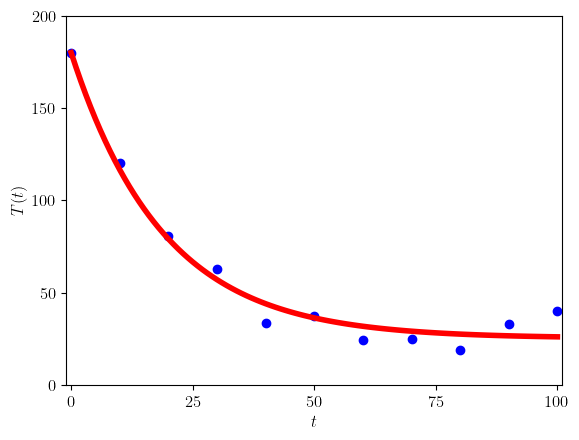

In [8]:
Tamin = 0; Tamax = 100; kmin = 0; kmax = 1  # lower/upper bounds
θG = [20, 0.05]  # Initial estimate of the parameter values
lb = [Tamin, kmin]
ub = [Tamax, kmax]
(xopt, fopt) = Optimise(funmle, θG, lb, ub)  # Call to NLopt
Tamle = xopt[0]  # Store the MLE
kmle = xopt[1]   # Store the MLE
fmle = fopt      # Store the log-likelihood at the MLE

def Tmle(t_val):
    return xopt[0] + (T0 - xopt[0]) * np.exp(-xopt[1] * t_val)

# p2 - superimpose the MLE solution on the observed data plot
fig2, ax2 = plt.subplots()
Tmle_vals = Tmle(tt)
ax2.plot(tt, Tmle_vals, linewidth=4, color='red')
ax2.scatter(t, data, color='blue')  
ax2.set_xlabel(r"$t$",fontsize=12)
ax2.set_ylabel(r"$T(t)$",fontsize=12)
ax2.set_xlim(t[0]-1, t[-1]+1)
ax2.set_ylim(0, 200)
ax2.set_xticks([0,25,50,75,100])
ax2.set_xticklabels([r"$0$", r"$25$", r"$50$", r"$75$", r"$100$"],fontsize=12)
ax2.set_yticks([0,50,100,150,200])
ax2.set_yticklabels([r"$0$", r"$50$", r"$100$", r"$150$", r"$200$"],fontsize=12);

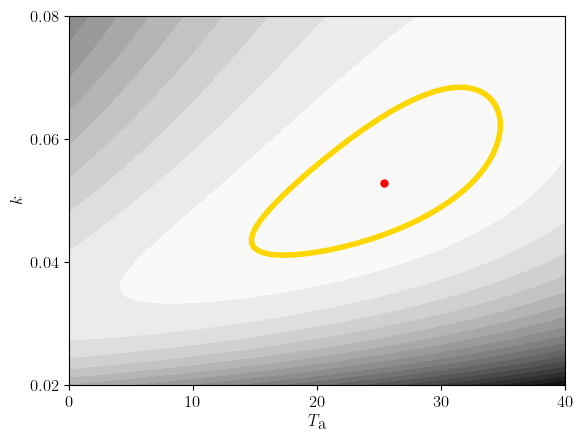

In [9]:
# Evaluate the log-likelihood on a Q by Q discretisation of the parmeter space
Q = 100  # Q by Q discretisation
Taa = np.linspace(0, 40, Q)  # Range of Ta values
kk = np.linspace(0.02, 0.08, Q)  # Range of k values
df = 2  # degrees of freedom for the asymptotic threshold value
llstar = -stats.chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

# Create a meshgrid for contour plotting
TAA, KK = np.meshgrid(Taa, kk)
def funmle_grid(Ta, k):
    return funmle(np.array([Ta, k])) - fopt
Z = np.vectorize(funmle_grid)(TAA, KK)

# p3 - the loglikelihood
fig3, ax3 = plt.subplots()
cf2 = ax3.contourf(TAA, KK, Z, cmap='gray', levels=20)
ax3.scatter([Tamle], [kmle], s=25, color='red')
ax3.contour(TAA, KK, Z, levels=[llstar], linewidths=4, colors='gold',linestyles='solid')
ax3.set_xlabel(r"$T_{\textrm{a}}$",fontsize=12)
ax3.set_ylabel(r"$k$",fontsize=12)
ax3.set_xlim(0, 40)
ax3.set_xticks([0,10,20,30,40])
ax3.set_xticklabels([r"$0$", r"$10$", r"$20$", r"$30$", r"$40$"],fontsize=12)
ax3.set_ylim(0.02,0.08)
ax3.set_yticks([0.02,0.04,0.06,0.08]);
ax3.set_yticklabels([r"$0.02$", r"$0.04$", r"$0.06$", r"$0.08$"],fontsize=12);

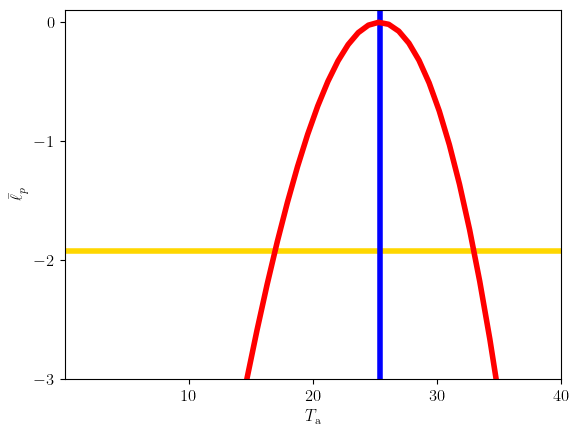

In [10]:
df = 1  # degrees of freedom for the asymptotic threshold value for the univariate profile likelihood
llstar = -stats.chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

def univariateTa(Ta):
    # Function to compute the univariate profile likelihood for Ta
    # a vector for nuisance parameter k
    def funTa(a):
        return loglhood(data, T0, np.array([Ta, a[0]]), σ)  # evaluate the log-likelihood at a specified value Ta
    θG_inner = [kmle]  # Estimate of the nuisance parameter k
    lb_inner = [kmin]  # Lower bound for the nuisance parameter k
    ub_inner = [kmax]  # Upper bound for the nuisance parameter k
    (xopt_inner, fopt_inner) = Optimise(funTa, θG_inner, lb_inner, ub_inner)  # Call to NLopt
    return fopt_inner, xopt_inner  # Return the profile log-likelihood and value of the nuisance parameter

def f_Ta(x):
    return univariateTa(x)[0]

M = 50  # Take a grid of M points to plot the univariate profile likelihood
Tarange = np.linspace(0, 40, M)
ff_Ta = np.zeros(M)
for i in range(M):
    ff_Ta[i] = univariateTa(Tarange[i])[0]

# p3 - univariate profile for Ta
fig3, ax3 = plt.subplots()
ax3.axhline(y=llstar, linewidth=4, color='gold')  # Plot the horizontal line at threshold
ax3.axvline(x=Tamle, linewidth=4, color='blue')   # Superimpose vertical line at MLE Ta
sp2 = UnivariateSpline(Tarange, ff_Ta - np.max(ff_Ta), k=3, w=np.ones(len(Tarange)), s=0.005)  # Use UnivariateSpline for interpolation
yy_Ta = sp2(Tarange)
ax3.plot(Tarange, yy_Ta, linewidth=4, color='red')
ax3.set_xlim(Tarange[0], Tarange[-1])
ax3.set_ylim(-3.0,0.1)
ax3.set_xticks([10,20,30,40])
ax3.set_xticklabels([r"$10$", r"$20$", r"$30$", r"$40$"],fontsize=12)
ax3.set_yticks([0,-1,-2,-3]);
ax3.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"],fontsize=12)
ax3.set_xlabel(r"$T_\mathrm{a}$",fontsize=12)
ax3.set_ylabel(r"$\bar{\ell}_p$",fontsize=12);

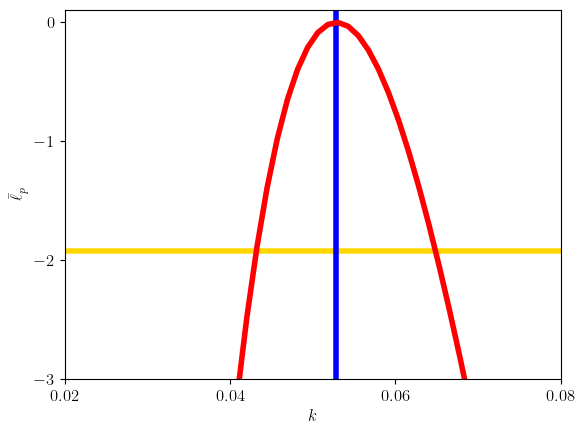

In [11]:
df = 1  # degrees of freedom for the asymptotic threshold value for the univariate profile likelihood
llstar = -stats.chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

def univariatek(k):
    # Function to compute the univariate profile likelihood for k
    def funk(a):
        return loglhood(data, T0, np.array([a[0], k]), σ)  # evaluate the log-likelihood at a specified value k
    θG_inner = [Tamle]  # Estimate of the nuisance parameter Ta
    lb_inner = [Tamin]  # Lower bound for the nuisance parameter Ta
    ub_inner = [Tamax]  # Upper bound for the nuisance parameter Ta
    (xopt_inner, fopt_inner) = Optimise(funk, θG_inner, lb_inner, ub_inner)  # Call to NLopt
    return fopt_inner, xopt_inner  # Return the profile log-likelihood and value of the nuisance parameter

def f_k(x):
    return univariatek(x)[0]

krange = np.linspace(0.02, 0.08, M)
ff_k = np.zeros(M)
for i in range(M):
    ff_k[i] = univariatek(krange[i])[0]

# p4 - univariate profile for k
fig4, ax4 = plt.subplots()
ax4.axhline(y=llstar, linewidth=4, color='gold')  # Plot horizontal line for k profile likelihood
ax4.axvline(x=kmle, linewidth=4, color='blue')      # Plot vertical line at MLE k
sp3 = UnivariateSpline(krange, ff_k - np.max(ff_k), k=3, w=np.ones(len(krange)), s=0.005)
yy_k = sp3(krange)
ax4.plot(krange, yy_k, linewidth=4, color='red')
ax4.set_xlim(krange[0],krange[-1])
ax4.set_ylim(-3.0,0.1)
ax4.set_xticks([0.02,0.04,0.06,0.08])
ax4.set_xticklabels([r"$0.02$", r"$0.04$", r"$0.06$", r"$0.08$"],fontsize=12)
ax4.set_yticks([0,-1,-2,-3]);
ax4.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"],fontsize=12);
ax4.set_xlabel(r"$k$",fontsize=12)
ax4.set_ylabel(r"$\bar{\ell}_p$",fontsize=12);

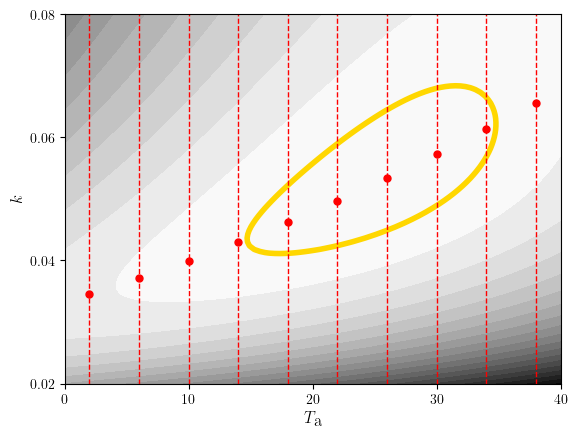

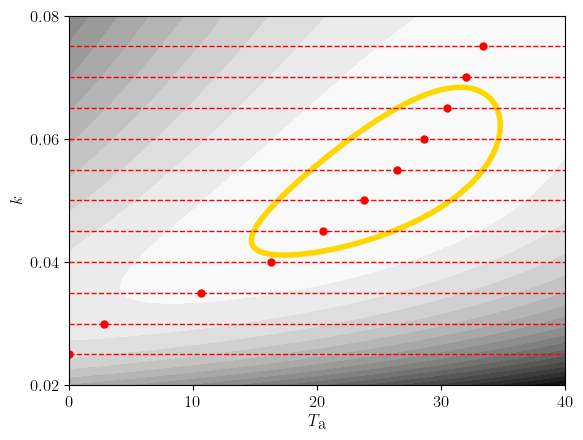

In [12]:
# Re-evaluate the normalised log-likelihood contour plots with additional markers
Q = 100  # Evaluate the log-likelihood on a Q by Q discretisation
Taa = np.linspace(0, 40, Q)  # Range of Ta values
kk = np.linspace(0.02, 0.08, Q)  # Range of k values
df = 2  # degrees of freedom for the asymptotic threshold value
llstar = -stats.chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

# p1: filled contour plot of the normalised log-likelihood function
TAA, KK = np.meshgrid(Taa, kk)
Z = np.vectorize(funmle_grid)(TAA, KK)
fig5, ax5 = plt.subplots()
cf = ax5.contourf(TAA, KK, Z, cmap='gray', levels=20)
ax5.contour(TAA, KK, Z, levels=[llstar], linewidths=4, colors='gold',linestyles='solid')
ax5.set_xlim(0, 40)
ax5.set_xticks([0,10,20,30,40])
ax5.set_xticklabels([r"$0$", r"$10$", r"$20$", r"$30$", r"$40$"])
ax5.set_ylim(0.02, 0.08)
ax5.set_yticks([0.02,0.04,0.06,0.08])
ax5.set_yticklabels([r"$0.02$", r"$0.04$", r"$0.06$", r"$0.08$"])
ax5.set_xlabel(r"$T_{\textrm{a}}$",fontsize=12)
ax5.set_ylabel(r"$k$",fontsize=12)
Tarange_coarse = np.arange(2, 38+1, 4)  # Coarse discretisation of the interest parameter Tamin=0, xmax=40, 
ax5.vlines(Tarange_coarse, ymin=0.02, ymax=0.08, colors='red', linestyles='dashed', linewidth=1)
nu = np.zeros(10)
for i in range(10):
    # Optimize out the value of the nuisance parameter k that maximises the normalised log-likelihood along each vertical line
    nu_val = univariateTa(Tarange_coarse[i])[1][0]
    nu[i] = nu_val
    ax5.scatter(Tarange_coarse[i], nu_val, s=25, color='red')
    
# p2: second contour with horizontal markers
fig6, ax6 = plt.subplots()
cf2 = ax6.contourf(TAA, KK, Z, cmap='gray', levels=20)
ax6.contour(TAA, KK, Z, levels=[llstar], linewidths=4, colors='gold',linestyles='solid')
ax6.set_xlim(0, 40)
ax6.set_xticks([0,10,20,30,40])
ax6.set_xticklabels([r"$0$", r"$10$", r"$20$", r"$30$", r"$40$"],fontsize=12)
ax6.set_ylim(0.02, 0.08)
ax6.set_yticks([0.02,0.04,0.06,0.08])
ax6.set_yticklabels([r"$0.02$", r"$0.04$", r"$0.06$", r"$0.08$"],fontsize=12)
ax6.set_xlabel(r"$T_{\textrm{a}}$",fontsize=12)
ax6.set_ylabel(r"$k$",fontsize=12)
krange_coarse = np.arange(0.025, 0.075+0.005, 0.005)  # Coarse discretisation of the interest parameter k
ax6.hlines(krange_coarse, xmin=0, xmax=40, colors='red', linestyles='dashed', linewidth=1)
nu2 = np.zeros(len(krange_coarse))
for i in range(len(krange_coarse)):
    nu2_val = univariatek(krange_coarse[i])[1][0]
    nu2[i] = nu2_val
    ax6.scatter(nu2_val, krange_coarse[i], s=25, color='red')


# Prediction: Two approaches

## 1. Grid up the log-likelihood function,

## 2. Rejection sampling of the log-likelihood function to generate M samples, 
    
       
\begin{equation}
\large{\bar{\ell}(\theta \mid T^{o}(t)) \ge \bar{\ell}^*}
\end{equation}    
    
## Here we follow the second option.    

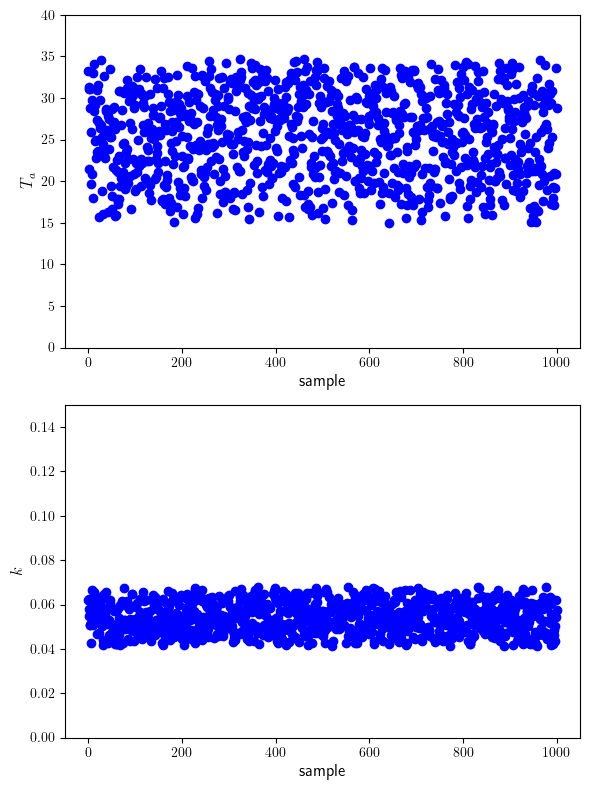

In [13]:
Tamin = 0; Tamax = 40; kmin = 0.0; kmax = 0.15  # Define simple box limits around the parameter space
df = 2  # degrees of freedom for the asymptotic threshold value
llstar = -stats.chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

M = 1000  # Number of samples to be drawn
Tasampled = np.zeros(M)
ksampled = np.zeros(M)
lls = np.zeros(M)
kount = 0
while kount < M:
    Tag = np.random.uniform(Tamin, Tamax)  # Draw a sample of Ta at random within the box limits
    kg = np.random.uniform(kmin, kmax)       # Draw a sample of k at random within the box limits
    if (loglhood(data, T0, np.array([Tag, kg]), σ) - fmle) >= llstar:
        kount += 1
        lls[kount-1] = loglhood(data, T0, np.array([Tag, kg]), σ) - fmle
        Tasampled[kount-1] = Tag
        ksampled[kount-1] = kg

# a1: plot samples of Ta
fig8, (ax8_top, ax8_bot) = plt.subplots(2, 1, figsize=(6,8))
ax8_top.scatter(range(M), Tasampled, color='blue')
ax8_top.set_xlabel("sample",fontsize=12)
ax8_top.set_ylabel(r"$T_a$",fontsize=12)
ax8_top.set_ylim(Tamin, Tamax)
# a2: plot samples of k
ax8_bot.scatter(range(M), ksampled, color='blue')
ax8_bot.set_xlabel("sample",fontsize=12)
ax8_bot.set_ylabel(r"$k$",fontsize=12)
ax8_bot.set_ylim(kmin, kmax)
plt.tight_layout()

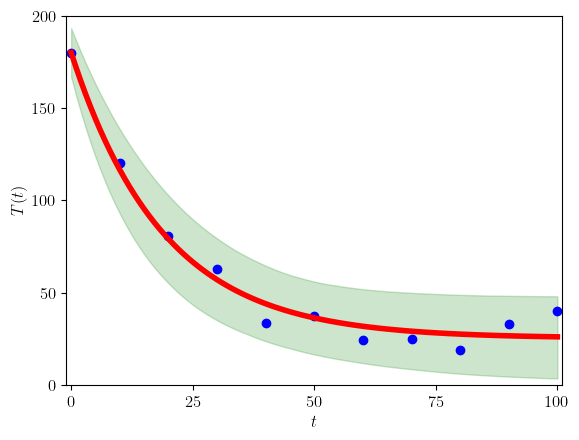

In [14]:
lower = np.full(len(tt), 10 * Tamle)  # Define vector on the fine discretisation of t that will store the lower limit of the prediction interval
upper = np.zeros(len(tt))             # Define vector on the fine discretisation of t that will store the upper limit of the prediction interval
q_low = stats.norm.ppf(0.05, loc=0, scale=σ)
q_high = stats.norm.ppf(0.95, loc=0, scale=σ)
for i in range(M):
    # For each parameter sample solve the process model
    def Ts(t_val):
        return Tasampled[i] + (T0 - Tasampled[i]) * np.exp(-ksampled[i] * t_val)
    for j in range(len(tt)):
        val_low = Ts(tt[j]) + q_low  # lower bound of the noise model at time tt[j]
        if val_low < lower[j]:
            lower[j] = val_low
        val_high = Ts(tt[j]) + q_high  # upper bound of the noise model at time tt[j]
        if val_high > upper[j]:
            upper[j] = val_high

# Plot the prediction interval region and the MLE prediction
fig9, ax9 = plt.subplots()
ax9.fill_between(tt, lower, upper, color='green', alpha=0.20)  # Plot the region between lower and upper bounds
# Superimpose MLE prediction
ax9.plot(tt, Tmle(tt), linewidth=4, color='red')
ax9.set_xlabel(r"$t$",fontsize=12)
ax9.set_ylabel(r"$T(t)$",fontsize=12)
ax9.set_xlim(tt[0]-1, tt[-1]+1)
ax9.set_ylim(0, 200)
ax9.set_xticks([0,25,50,75,100])
ax9.set_xticklabels([r"$0$", r"$25$", r"$50$", r"$75$", r"$100$"],fontsize=12)
ax9.set_yticks([0,50,100,150,200])
ax9.set_yticklabels([r"$0$", r"$50$", r"$100$", r"$150$", r"$200$"],fontsize=12)
ax9.scatter(t, data, color='blue');